# Códigos Tidene - Clusterização


### Leitura de dados iniciais

In [16]:
import sklearn
import pickle
import pandas as pd
import nltk

In [2]:
import csv

class readCorpus(object):
    def __init__(self,csvfile,list_of_fields_to_read=[],tokenizer=None,encoding='utf8'):
        self.csvfile = csvfile
        self.fields = list_of_fields_to_read
        self.tokenizer = tokenizer
        self.encoding = encoding
    
    def __iter__(self):
        f = open(self.csvfile,encoding=self.encoding, errors='ignore')
        reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_MINIMAL) #separador dos campos\n",
        headers = next(reader, None)
        if (len(self.fields) <= 0):
            self.fields = headers
        selected_field_indexes = []
        for idx,field in enumerate(headers):
            if field in self.fields:
                selected_field_indexes.append(idx)

        for line in reader:
            if line:
                yield [line[idx] for idx in selected_field_indexes] if (len(selected_field_indexes)>1) else (line[selected_field_indexes[0]] if not self.tokenizer else tokenizer.tokenize(line[selected_field_indexes[0]]))
                        

In [17]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import *    #https://www.nltk.org/api/nltk.tokenize.html

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer = nltk.tokenize.RegexpTokenizer("[a-zA-Z']+")
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in self.tokenizer.tokenize(doc) if (len(t)>2)]

class StemTokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.tokenizer = nltk.tokenize.RegexpTokenizer("[a-zA-Z']+")
    def __call__(self, doc):
        
        return [self.stemmer.stem(t) for t in self.tokenizer.tokenize(doc) if (len(t)>2)]


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', min_df=1)



pd_corpus =  pd.read_csv("toy.csv",encoding='utf8')
corpus = pd_corpus['data']
classes = pd_corpus['subgroup'].values.tolist()

## NOS OUTROS EXEMPLOS ESSAS DUAS ACOES (FIT E TRANSFORM) SAO FEITAS EM UMA SO, ATRAVES DO FIT_TRANSFORM ..
##   FIZ A SEPARACAO AQUI PARA PODER GRAVAR NO DISCO O VETORIZADOR E PODER USA-LO PARA VETORIZAR TEXTOS NOVOS DEPOIS
tfidf_vectorizer = tfidf_vectorizer.fit(corpus,classes) # treina o vetorizador
X_train_tfidf = tfidf_vectorizer.transform(corpus) # transforma os textos em uma matriz sparsa numpy


# gravando no disco vetorizador e a matriz vetorizada
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pickle", "wb"))
pickle.dump(X_train_tfidf, open("X_train_tfidf.pickle", "wb"))



In [22]:


X_train_tfidf = pickle.load(open("X_train_tfidf.pickle", "rb"))
train_classes = pd.read_csv('toy.csv',encoding='utf8')['subgroup'].values.tolist()
train_docs = readCorpus("toy.csv",list_of_fields_to_read=['subgroup','othersipcs','data']) #CORPUS ITERATOR


#test_docs = readCorpus("testtoy.csv",list_of_fields_to_read=['data'])          # ou pd.read_csv('testtoy.csv',encoding='utf8')['data']     #.values.tolist()
#test_classes = pd.read_csv('testtoy.csv',encoding='utf8')['subgroup'].values.tolist()
#X_test_tfidf = tfidf_vectorizer.transform(test_docs)

In [23]:
from sklearn.cluster import KMeans

k = 2

km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, verbose=1)
km_vectorizer = km.fit(X_train_tfidf)
pickle.dump(km_vectorizer, open("km_vectorizer.pickle", "wb"))

Initialization complete
Iteration  0, inertia 27.355
Iteration  1, inertia 13.281
Iteration  2, inertia 13.069
Converged at iteration 2: center shift 0.000000e+00 within tolerance 9.279556e-08
Initialization complete
Iteration  0, inertia 24.900
Iteration  1, inertia 13.069
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.279556e-08
Initialization complete
Iteration  0, inertia 26.848
Iteration  1, inertia 13.906
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.279556e-08
Initialization complete
Iteration  0, inertia 26.613
Iteration  1, inertia 13.838
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.279556e-08
Initialization complete
Iteration  0, inertia 26.618
Iteration  1, inertia 13.482
Iteration  2, inertia 13.264
Converged at iteration 2: center shift 0.000000e+00 within tolerance 9.279556e-08


In [5]:
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

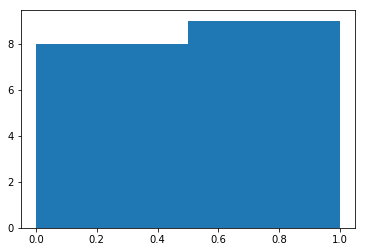

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(km.labels_,bins=k)
plt.show()

In [25]:
clusters = {}

for idx,(subgroup,othersipcs,data) in enumerate(train_docs):
    if km.labels_[idx] in clusters.keys():
        clusters[km.labels_[idx]].append([subgroup,othersipcs,data[0:300]]) 
    else:
        clusters[km.labels_[idx]]=[[subgroup,othersipcs,data[0:300]]]
    

print(" Clusters \n")

for k in clusters.keys():
    print("+++++ Cluster ",k," +++++\n")
    for ipc,othersipcs,text in clusters[k]:
        print (ipc," ",othersipcs," ",text,"\n")



# OPCAO PARA SALVAR EM ARQUIVOS COM O NOME DO CLUSTER, DENTRO DE UMA PASTA CLUSTERS
#for idx,(subgroup,data,otherspcis) in enumerate(train_docs):
#    arq = "cluster" + str(km.labels_[idx])
 #   with open("CLUSTERS/"+arq, "a") as myfile:
  #      myfile.write(subgroup+'\t'+otherspcis+'\t'+data+'\n')  # separarado por \t
  #  myfile.close()



 Clusters 

+++++ Cluster  1  +++++

B03B00402   B07B00408   separation apparatus this invention relates to a method for separation of a light material from a heavier material a separation table of vibrator type and a cyclone and a fan means being found the invention also relates to an arrangement for making the separation possible it is previously known by m 

B03B00500   B01D01102-E02F00388   method and installation for desalinating sand and suction hopper comprising such an installation the invention relates to the desalination of sand extracted from the sea the desalination of sand is a primary precondition if sea sand is to be able to be used on land the requirement imposed is that th 

B03B00546   B03B01100   device for sorting a mix of objects the invention relates to a device for sorting a mix of objects using a bed of fluidized material comprising a frame a porous bottom for supporting the material to be fluidized during operation means for supplying pressurized air to the por